생성된 클러스터 수: 6
클러스터 0: 109 개의 데이터 포인트
클러스터 1: 0 개의 데이터 포인트
클러스터 2: 169 개의 데이터 포인트
클러스터 3: 68 개의 데이터 포인트
클러스터 4: 98 개의 데이터 포인트
클러스터 5: 0 개의 데이터 포인트
실제 클러스터 수: 6


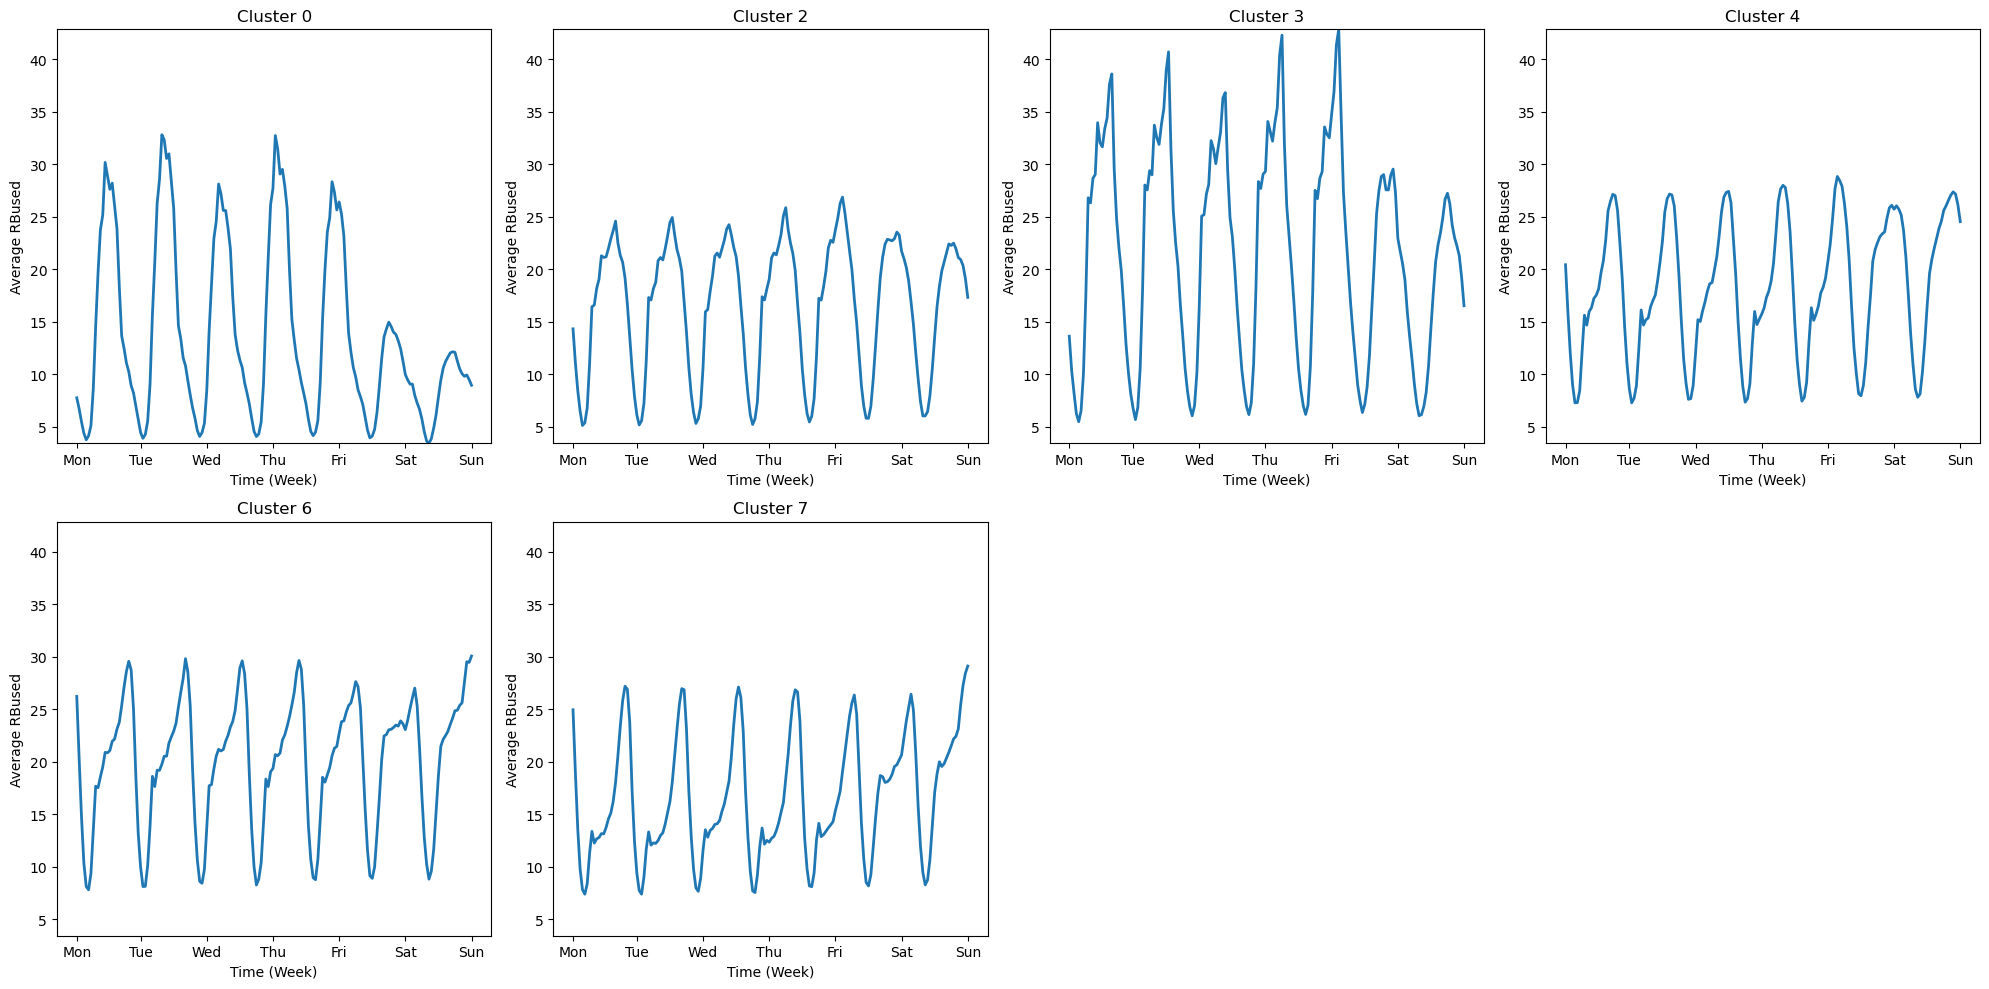


클러스터별 사이트 수:
cluster
0    109
2    169
3     68
4     98
6     82
7    120
Name: count, dtype: int64

클러스터 통계 요약:
클러스터 수: 6
최소 사이트 수를 가진 클러스터: 68 사이트
최대 사이트 수를 가진 클러스터: 169 사이트
평균 사이트 수: 107.67 사이트
중앙값 사이트 수: 103.5 사이트

클러스터별 사이트 비율:
클러스터 0: 16.87%
클러스터 2: 26.16%
클러스터 3: 10.53%
클러스터 4: 15.17%
클러스터 6: 12.69%
클러스터 7: 18.58%


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

# 데이터 로드 및 전처리
df = pd.read_csv('../ELG_Busan_PoC_per_CA_site_0226_0519.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1h').agg({'RBused': 'mean'}).reset_index()
df_hourly['day_of_week'] = df_hourly['timestamp'].dt.dayofweek
df_hourly['hour'] = df_hourly['timestamp'].dt.hour
df_hourly['is_weekend'] = df_hourly['day_of_week'].isin([5, 6])

weekly_pattern = df_hourly.groupby(['enbid_pci', 'day_of_week', 'hour'])['RBused'].mean().unstack(level=[1,2])
weekly_pattern.columns = [f'day{day}_hour{hour}' for day, hour in weekly_pattern.columns]

# k-Shape 클러스터링을 위한 데이터 준비
time_series_data = to_time_series_dataset(weekly_pattern.fillna(0).values)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
time_series_data_scaled = scaler.fit_transform(time_series_data)

# 수정된 3단계 계층적 클러스터링 수행
def hierarchical_clustering(data, depth=3):
    if depth == 0:
        return np.zeros(len(data))
    
    kshape = KShape(n_clusters=2, random_state=42)
    labels = kshape.fit_predict(data)
    
    for i in range(2):
        sub_data = data[labels == i]
        if len(sub_data) > 0:
            sub_labels = hierarchical_clustering(sub_data, depth - 1)
            labels[labels == i] = sub_labels + (i * (2 ** (depth - 1)))
        else:
            # 빈 클러스터인 경우, 강제로 두 개의 서브클러스터 생성
            half = len(data) // 2
            labels[labels == i][:half] = i * (2 ** (depth - 1))
            labels[labels == i][half:] = i * (2 ** (depth - 1)) + 2 ** (depth - 2)
    
    return labels

final_labels = hierarchical_clustering(time_series_data_scaled)

# 여기서부터 새로 추가되는 코드
n_clusters = len(np.unique(final_labels))
print(f"생성된 클러스터 수: {n_clusters}")

# 각 클러스터의 크기 출력
for i in range(n_clusters):
    cluster_size = np.sum(final_labels == i)
    print(f"클러스터 {i}: {cluster_size} 개의 데이터 포인트")

# 결과를 원본 데이터에 추가
weekly_pattern['cluster'] = final_labels

# 클러스터별 RBused의 평균 계산
cluster_means = weekly_pattern.groupby('cluster').mean()

# 실제 클러스터 수 확인
n_clusters = len(cluster_means)
print(f"실제 클러스터 수: {n_clusters}")

# 클러스터별 평균을 시각화
existing_clusters = sorted(cluster_means.index.unique())
n_clusters = len(existing_clusters)
n_cols = min(4, n_clusters)
n_rows = (n_clusters + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

for i, cluster in enumerate(existing_clusters):
    ax = axes[i]
    cluster_data = cluster_means.loc[cluster, :]  # 'cluster' 열은 이미 제외됨
    ax.plot(cluster_data, linewidth=2)
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('Time (Week)')
    ax.set_ylabel('Average RBused')
    
    # x축 레이블 조정
    n_ticks = 7
    tick_locations = np.linspace(0, len(cluster_data) - 1, n_ticks).astype(int)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # y축 범위 설정 (모든 그래프에 동일한 스케일 적용)
    ax.set_ylim(cluster_means.min().min(), cluster_means.max().max())

# 사용하지 않는 서브플롯 제거
for i in range(n_clusters, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 클러스터별 사이트 수 출력
cluster_counts = weekly_pattern['cluster'].value_counts().sort_index()
print("\n클러스터별 사이트 수:")
print(cluster_counts)

# 추가적인 클러스터 분석
print("\n클러스터 통계 요약:")
print(f"클러스터 수: {len(cluster_counts)}")
print(f"최소 사이트 수를 가진 클러스터: {cluster_counts.min()} 사이트")
print(f"최대 사이트 수를 가진 클러스터: {cluster_counts.max()} 사이트")
print(f"평균 사이트 수: {cluster_counts.mean():.2f} 사이트")
print(f"중앙값 사이트 수: {cluster_counts.median()} 사이트")

# 클러스터별 사이트 비율 계산
total_sites = cluster_counts.sum()
print("\n클러스터별 사이트 비율:")
for cluster, count in cluster_counts.items():
    percentage = (count / total_sites) * 100
    print(f"클러스터 {cluster}: {percentage:.2f}%")

enbid_pci 별 클러스터 저장을 위한 작업. (CSV파일로 저장)

In [ ]:
import pandas as pd

# enbid_pci, 클러스터 번호, 위도, 경도를 포함하는 데이터프레임 생성
cluster_results = weekly_pattern.reset_index()[['enbid_pci', 'cluster']]

# 위경도 정보 추가
location_info = df[['enbid_pci', 'ru_svc_lat_val', 'ru_svc_lng_val']].drop_duplicates(subset='enbid_pci')
cluster_results = cluster_results.merge(location_info, on='enbid_pci', how='left')

# 클러스터 번호를 기준으로 오름차순 정렬
cluster_results_sorted = cluster_results.sort_values('cluster')

# CSV 파일로 저장
output_path = 'cluster_results_with_location.csv'
cluster_results_sorted.to_csv(output_path, index=False)
print(f"클러스터링 결과가 {output_path}에 저장되었습니다.")

지도에 시각화

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from branca.element import Template, MacroElement

# CSV 파일 로드
df = pd.read_csv('cluster_results_with_location.csv')

# 지도 생성
center_lat = df['ru_svc_lat_val'].mean()
center_lng = df['ru_svc_lng_val'].mean()

m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

# 클러스터별 색상 정의 (더 뚜렷한 색상으로 변경)
#colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
#          '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
#          '#FFA500', '#FFC0CB', '#40E0D0', '#FF69B4', '#7B68EE', '#98FB98', '#DDA0DD']

colors = ['#6583E5', '#F2CB6A', '#58E290', '#C76DEF', '#E66868', '#FFA500', '#FFC0CB', '#40E0D0', '#FF69B4', '#7B68EE', '#98FB98', '#DDA0DD']



# 데이터 포인트 추가
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['ru_svc_lat_val'], row['ru_svc_lng_val']],
        radius=8,
        popup=f"enbid_pci: {row['enbid_pci']}, Cluster: {row['cluster']}",
        color='black',
        fill=True,
        fillColor=colors[int(row['cluster']) % len(colors)],
        fillOpacity=0.7,
        stroke=True,
        weight=2
    ).add_to(m)

# 커스텀 범례 생성
legend_html = '''
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    top: 10px;
    right: 10px;
    width: 150px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: #ffffff;
    border: 2px solid grey;
    border-radius: 6px;
    padding: 10px;
    ">
    <div style="font-weight: bold; margin-bottom: 5px;">Clusters</div>
    {% for cluster in range(this.max_cluster + 1) %}
    <div>
        <span style="
            display: inline-block;
            width: 15px;
            height: 15px;
            margin-right: 5px;
            background-color: {{this.color_list[cluster]}};
            border: 1px solid #000;
        "></span>
        Cluster {{cluster}}
    </div>
    {% endfor %}
</div>
{% endmacro %}
'''

# 범례 클래스 정의
class Legend(MacroElement):
    def __init__(self, color_list, max_cluster):
        super(Legend, self).__init__()
        self.color_list = color_list
        self.max_cluster = max_cluster
        self._template = Template(legend_html)

# 범례 추가
legend = Legend(colors, df['cluster'].max())
m.get_root().add_child(legend)

# 지도 저장
m.save("cluster_map_with_legend.html")


correlation coefficient를 통한 클러스터링 평가

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# 원본 데이터 로드
df = pd.read_csv('../ELG_Busan_PoC_per_CA_site_0226_0519.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 시간대별 평균 RBused 계산
df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1h').agg({'RBused': 'mean'}).reset_index()
df_hourly['day_of_week'] = df_hourly['timestamp'].dt.dayofweek
df_hourly['hour'] = df_hourly['timestamp'].dt.hour

# 일주일 패턴 생성
weekly_pattern = df_hourly.groupby(['enbid_pci', 'day_of_week', 'hour'])['RBused'].mean().unstack(level=[1,2])
weekly_pattern.columns = [f'day{day}_hour{hour}' for day, hour in weekly_pattern.columns]

# 클러스터링 결과 로드
cluster_results = pd.read_csv('../cluster_results_with_location.csv')

# 클러스터별 평균 패턴 계산
cluster_means = weekly_pattern.join(cluster_results.set_index('enbid_pci')['cluster']).groupby('cluster').mean()

# 상관계수 계산 함수
def calculate_correlation(row, cluster_mean):
    return pearsonr(row, cluster_mean)[0]

# 카테고리 정의 함수
def categorize_accuracy(acc):
    if acc >= 0.8:
        return '매우 좋음'
    elif acc >= 0.7:
        return '좋음'
    elif acc >= 0.6:
        return '허용 가능'
    else:
        return '개선 필요'

# 각 enbid_pci에 대한 정확도(상관계수) 계산
accuracies = []
for enbid_pci, row in weekly_pattern.iterrows():
    cluster = cluster_results.loc[cluster_results['enbid_pci'] == enbid_pci, 'cluster'].values[0]
    accuracy = calculate_correlation(row, cluster_means.loc[cluster])
    category = categorize_accuracy(accuracy)
    accuracies.append({'enbid_pci': enbid_pci, 'cluster': cluster, 'accuracy': accuracy, 'category': category})

# 결과를 DataFrame으로 변환
accuracy_df = pd.DataFrame(accuracies)

# 클러스터별 평균 상관계수 계산 및 오름차순 정렬
cluster_mean_accuracy = accuracy_df.groupby('cluster')['accuracy'].mean().sort_values()

# 결과를 클러스터 번호와 상관계수 기준으로 오름차순 정렬
accuracy_df_sorted = accuracy_df.sort_values(['cluster', 'accuracy'])

# CSV 파일 생성
with open('clustering_accuracy_sorted_with_categories.csv', 'w') as f:
    # 클러스터별 평균 상관계수 작성
    f.write("클러스터별 평균 상관계수:\n")
    for cluster, mean_accuracy in cluster_mean_accuracy.items():
        f.write(f"Cluster {cluster}: {mean_accuracy:.4f}\n")
    f.write("\n")  # 빈 줄 추가

    # 정렬된 데이터프레임을 CSV로 저장
    accuracy_df_sorted.to_csv(f, index=False)

print("클러스터링 정확도가 clustering_accuracy_sorted_with_categories.csv 파일로 저장되었습니다.")

# 전체 정확도 통계
print("\n전체 정확도 통계:")
print(accuracy_df['accuracy'].describe())

# 클러스터별 평균 정확도 (내림차순)
print("\n클러스터별 평균 정확도 (내림차순):")
print(accuracy_df.groupby('cluster')['accuracy'].mean().sort_values(ascending=False))

# 카테고리별 enbid_pci 수
print("\n카테고리별 enbid_pci 수:")
print(accuracy_df['category'].value_counts())

# 상위 10개 enbid_pci (가장 정확한 클러스터링)
print("\n상위 10개 enbid_pci (가장 정확한 클러스터링):")
print(accuracy_df.nlargest(10, 'accuracy'))

# 하위 10개 enbid_pci (가장 부정확한 클러스터링)
print("\n하위 10개 enbid_pci (가장 부정확한 클러스터링):")
print(accuracy_df.nsmallest(10, 'accuracy'))

클러스터링 정확도가 clustering_accuracy_sorted_with_categories.csv 파일로 저장되었습니다.

전체 정확도 통계:
count    645.000000
mean       0.884566
std        0.112823
min       -0.509540
25%        0.862751
50%        0.916078
75%        0.943377
max        0.982158
Name: accuracy, dtype: float64

클러스터별 평균 정확도 (내림차순):
cluster
7    0.901700
3    0.901220
4    0.892455
0    0.878437
6    0.877299
2    0.868566
Name: accuracy, dtype: float64

카테고리별 enbid_pci 수:
category
매우 좋음    572
좋음        41
개선 필요     17
허용 가능     16
Name: count, dtype: int64

상위 10개 enbid_pci (가장 정확한 클러스터링):
     enbid_pci  cluster  accuracy category
477  37100_295        0  0.982158    매우 좋음
253  35540_105        2  0.979751    매우 좋음
113  34555_125        0  0.978861    매우 좋음
237  34805_306        3  0.978853    매우 좋음
66   34342_244        0  0.978211    매우 좋음
140  34759_112        0  0.977956    매우 좋음
478  37100_444        0  0.977711    매우 좋음
33   34133_101        2  0.977011    매우 좋음
72   34344_242        2  0.975863    매우 좋음
279  35722

/var/folders/6y/gvfh979s4nb35bcvpht0ntlm0000gn/T/ipykernel_6840/928424434.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(row, cluster_mean)[0]
